# Summary

Exploratory data analysis of draft data (e.g. win rates)

# Introduction

I will explore the summary and draft data.  This will look at the deck-level data and not get into 
specific cards. 

In [1]:
# Setup Notebook
import os
if os.path.basename(os.getcwd()) != "mtg-modeling":
    get_ipython().run_line_magic("run", '-i "../../scripts/notebook_header.py"')  # type: ignore

Changed working directory to: /root/mtg-modeling


In [284]:
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import time
import polars as pl
from datetime import timedelta

In [3]:
SET_CODE = "BLB"

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{SET_CODE}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{SET_CODE}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{SET_CODE}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{SET_CODE}_Game_PD_Cards.parquet"


# Summary Data

Below is the summary data for the Bloomburrow Premier Draft data from 17Lands.

You can see we have data from 07-30 through 08-18.  
The average win rate for the 17Lands players is 54.7%, which indicates the user base is more highly 
skilled than the average Arena draft player by a healthy margin.
The average number of turns is 8.9.  This should be compared to other sets understand the speed of 
this sets.
There is a total of 680,000 games played, with an average of 5.8 games per draft.
This set has 276 cards and the average number of basic lands used is 22.2.

In [4]:
df_summary = pl.scan_parquet(summary_file)
df_summary.collect()

first_game,last_game,max_games,win_rate,start_rate,n_games,n_mul,n_opp_mul,mean_turns,max_turns,min_turns,n_drafts,n_matches,mean_matches,n_games_per_draft,n_cards,max_card,mean_land,max_land,min_land
str,str,i64,f64,f64,u32,i64,i64,f64,i64,i64,u32,i64,f64,f64,i32,i64,f64,i32,i32
"""2024-07-30 15:41:04""","""2024-08-18 23:59:52""",2,0.547108,0.500285,679966,92172,96719,8.88899,33,1,116804,680693,5.827651,5.821427,276,7,22.164273,37,11


# Draft Data



In [5]:
df_draft = pl.scan_parquet(draft_file)

In [138]:
df_draft.head(2).collect()

draft_id,n_builds,n_matches,n_games,n_wins,win_rate,rank,opp_rank,main_colors,opp_colors,start_rate,mul_rate,opp_mul_rate,mean_turns,draft_time,first_game_time,last_game_time,n_losses
str,i64,i64,u32,u32,f64,str,str,str,str,f64,f64,f64,f64,datetime[μs],datetime[μs],datetime[μs],u32
"""5472dd1763274e3fa9b497a86e8321…",0,3,3,0,0.0,"""silver""","""None""","""WG""","""UR""",0.0,0.0,0.333333,10.333333,2024-07-31 21:57:04,2024-07-31 22:21:12,2024-07-31 22:42:46,3
"""9de0d337fd7f44479694ef2238cefc…",1,9,9,7,0.777778,"""gold""","""None""","""BR""","""WR""",0.666667,0.111111,0.111111,7.888889,2024-08-16 16:56:36,2024-08-16 17:17:03,2024-08-16 21:06:25,2


## Color Decks

Let's explore the color decks. 

### Color Frequency

First I will look at the number of decks drafted for each color set.  The 10 two-color decks are the 
most frequent.  The Bloomburrow set is design for 10 two-color animal tribes, so this aligns with 
the design intent of the set.  Mono-color and multi-color decks are much lest frequent.

The Black-Green _Squirrels: Forage_ decks and the White-Green _Rabbits: Go-Wide_ decks are by far the most 
popular.  Most decks using Blue are much less favored.

See @fig-polar

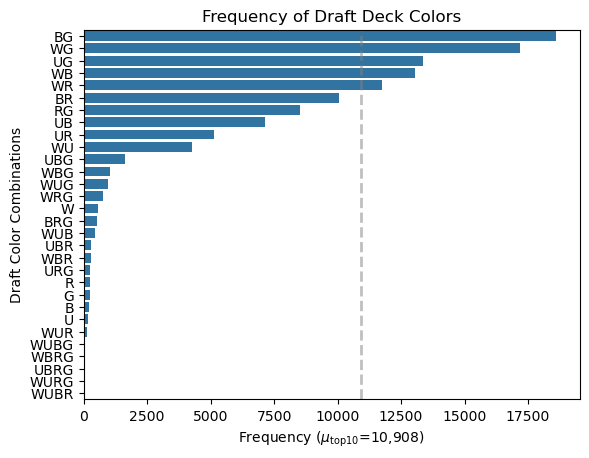

In [7]:
# | label: fig-polar
# | fig-cap: "A line plot on a polar axis"

colors = df_draft.group_by("main_colors").len().sort(by='len', descending=True).collect()
colors = colors.to_pandas()
freq_mu = colors["len"].head(10).mean()

plt.axvline(
    freq_mu, color="gray", linestyle="--", linewidth=2, alpha=0.5
)
sns.barplot(data=colors.head(30), x="len", y="main_colors")
plt.title("Frequency of Draft Deck Colors")
plt.xlabel(r"Frequency ($\mu_{\text{top}10}$=" + f"{freq_mu:,.0f})")
plt.ylabel("Draft Color Combinations")
plt.show()

Since Bloomburrow is designed with 2-color tribal decks in mind, I will focus on these pairings.  The most frequent drafted decks are Black-Green, White-Green, and Red-White.  The least drafted are Blue-Black, Blue-Red and White-Blue.

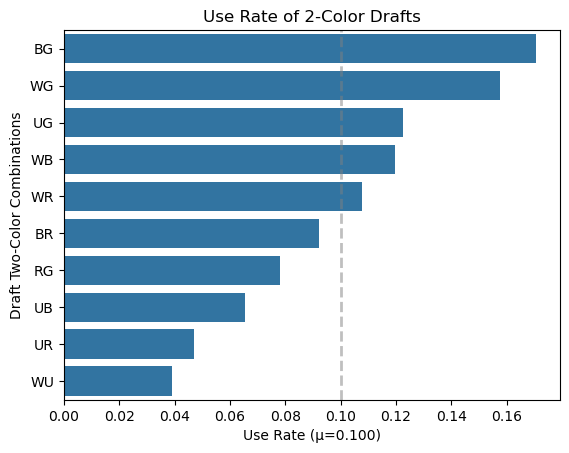

In [240]:
colors['use_rate'] = colors['len'] / colors['len'].sum()
colors = colors.sort_values("use_rate", ascending=False)

two_colors = colors[colors["main_colors"].str.len() == 2]

use_rate_mu = two_colors["use_rate"].mean()

plt.axvline(
    use_rate_mu, color="gray", linestyle="--", linewidth=2, alpha=0.5
)
sns.barplot(data=two_colors, x="use_rate", y="main_colors")
plt.title("Use Rate of 2-Color Drafts")
plt.xlabel(f"Use Rate (μ={use_rate_mu:0.3f})")
plt.ylabel("Draft Two-Color Combinations")
plt.show()

Next let's look at the color composition of the decks.  Below we can see that Green is the most 
frequently drafted color, with Black and White also favored.  Red and Blue are much less frequent.

The average draft use rate per component color is 40.0%.

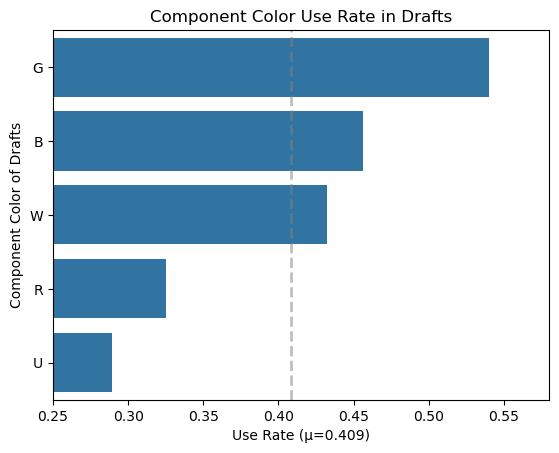

In [9]:
for color in ['W', 'U', 'B', 'R', 'G']:
    colors[color] = colors['main_colors'].apply(lambda x: True if color in x else False)

dfs = []
for color in ['W', 'U', 'B', 'R', 'G']:
    sums = colors[['len', color]].groupby(color).sum()
    use_rate = (sums.loc[True] / sums.sum()).values[0]
    dfs.append(pd.DataFrame({"color": color, "use_rate": use_rate}, index=[0]))
df = pd.concat(dfs).sort_values("use_rate", ascending=False).reset_index(drop=True)

use_rate_mu = df["use_rate"].mean()
plt.axvline(use_rate_mu, color="gray", linestyle="--", linewidth=2, alpha=0.5)
g = sns.barplot(data=df, x="use_rate", y="color")
g.set(xlim=(0.25, 0.58))
plt.title("Component Color Use Rate in Drafts")
plt.xlabel(f"Use Rate (μ={use_rate_mu:0.3f})")
plt.ylabel("Component Color of Drafts")
plt.show()

Deck use over time

...

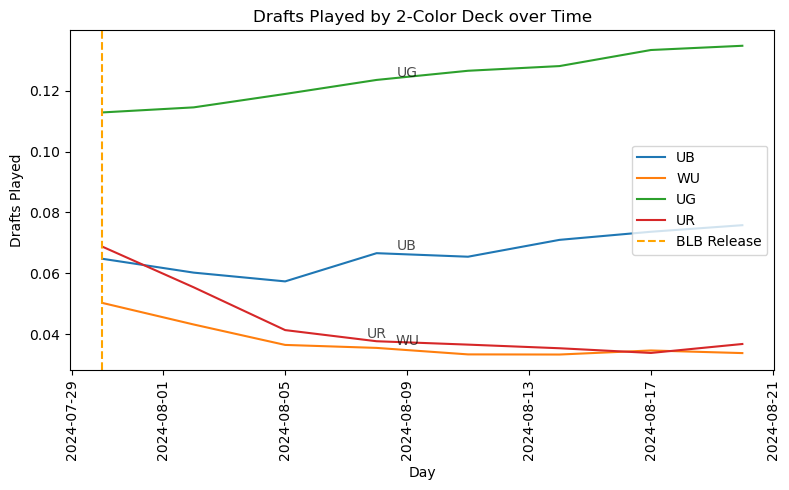

In [403]:
color_time = (
    (
        df_draft.filter(
            pl.col("main_colors").str.len_chars() == 2,
        )
        .group_by(pl.col("draft_time").dt.truncate("3d"), pl.col("main_colors"))
        .agg(
            pl.col("n_games").sum(),
            pl.col("n_wins").sum(),
        )
        .sort(by=["draft_time", "n_games"], descending=[False, True])
    )
    .with_columns(pl.col("draft_time") + timedelta(days=2))
    .collect()
    .to_pandas()
)

rank_time_sum = (
    color_time[["draft_time", "n_games"]].groupby(["draft_time"]).sum().reset_index()
)

color_time = color_time.merge(
    rank_time_sum, on="draft_time", suffixes=("", "_sum")
)
color_time["rank_pct"] = color_time["n_games"] / color_time["n_games_sum"]

color_time_mean = (
    color_time[["draft_time", "n_wins", "n_games"]]
    .groupby("draft_time")
    .sum()
    .reset_index()
)
color_time_mean["win_rate"] = color_time_mean["n_wins"] / color_time_mean["n_games"]


color_decks = ["UB", "WU", "UG", "UR"]
color_time = color_time.loc[color_time["main_colors"].isin(color_decks)]

mask = color_time["draft_time"] == pd.to_datetime("2024-08-08")
labels = color_time.loc[mask].sort_values("rank_pct", ascending=False)

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=color_time,
    x="draft_time",
    y="rank_pct",
    hue="main_colors",
    hue_order=color_decks,
    legend=True,
)

plt.axvline(
    x=pd.to_datetime("2024-07-30"), color="orange", linestyle="--", label="BLB Release"
)
for i, row in labels.iterrows():
    plt.text(
        row["draft_time"] + timedelta(days=i % 2),
        row["rank_pct"] + 0.001,
        str(row["main_colors"]),
        fontsize=10,
        alpha=0.7,
        ha="center",
    )
plt.xticks(rotation=90)
plt.title("Drafts Played by 2-Color Deck over Time")
plt.xlabel("Day")
plt.ylabel("Drafts Played")
plt.legend(loc="center right")
plt.tight_layout()
plt.show()

### Color Win Rates

In addition to the use rate of the colors, I will also look at the win rates of the colors.  First I calculate the weighted average win rate of 54.7%.  As we saw in the summary section, this indicates that the 17Lands player base has a higher win rate than the general draft player base.   

Below is a chart of the win rate for each color combination.  There are some mono-color decks with high win rates, but have very low use rates, so the results may be circumstantial with a small sample size.

In [10]:
mean_win_rate = df_summary.collect().to_pandas()['win_rate'].values[0]
print(f"Average Win Percentage: {mean_win_rate:0.2%}")

Average Win Percentage: 54.71%


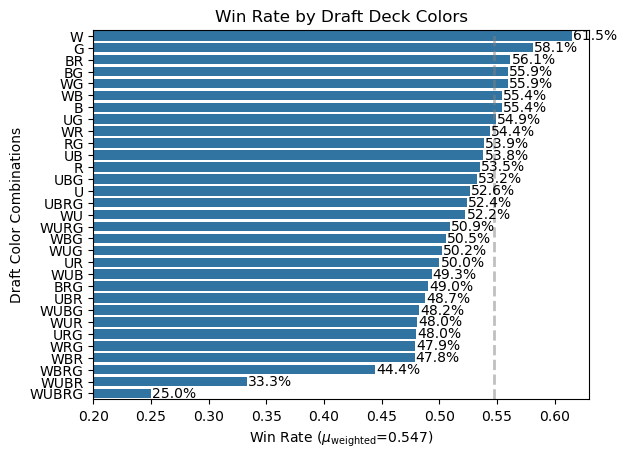

In [11]:
color_wins = (
    df_draft.group_by("main_colors")
    .agg(
        pl.col("n_games").sum(), 
        pl.col("n_wins").sum(),
        pl.col("n_losses").sum(),

    )
    .sort(by="n_games", descending=True)
    .collect()
)
color_wins = color_wins.to_pandas()
color_wins["win_rate"] = color_wins["n_wins"] / color_wins["n_games"]
color_wins["loss_rate"] = color_wins["n_losses"] / color_wins["n_games"]
color_wins = color_wins.sort_values("win_rate", ascending=False).reset_index(drop=True)

n = 50
plt.axvline(mean_win_rate, color="gray", linestyle="--", linewidth=2, alpha=0.5)
g = sns.barplot(data=color_wins.head(n), x="win_rate", y="main_colors")
g.set(xlim=(0.20, 0.63))
for index, row in color_wins.head(n).iterrows():
    plt.text(row["win_rate"] + 0.001, index, f"{row['win_rate']:.1%}", va="center")
plt.title("Win Rate by Draft Deck Colors")
plt.xlabel(r"Win Rate ($\mu_{\text{weighted}}$" + f"={mean_win_rate:0.3f})")
plt.ylabel("Draft Color Combinations")
plt.show()

Focusing on the 2-color decks, the Black-Red _Lizards: Opponents Lose Life_ is the highest win rate, but with a fairly low use rate.  The White-Red _Rabbits: Go-Wide_ and Black-Green _Squirrels: Forage_ are the most popular decks and have high win rates.

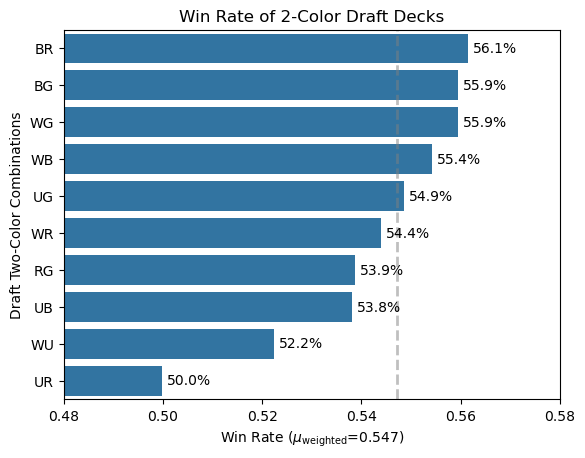

In [12]:
color_mask = color_wins["main_colors"].isin(colors.head(10)['main_colors'])
two_color_wins = color_wins.loc[color_mask].sort_values("win_rate", ascending=False).reset_index(drop=True)

plt.axvline(mean_win_rate, color="gray", linestyle="--", linewidth=2, alpha=0.5)
g = sns.barplot(data=two_color_wins, x="win_rate", y="main_colors")
g.set(xlim=(0.48, 0.58))
for index, row in two_color_wins.iterrows():
    plt.text(row["win_rate"] + 0.001, index, f"{row['win_rate']:.1%}", va="center")
plt.title("Win Rate of 2-Color Draft Decks")
plt.xlabel(r"Win Rate ($\mu_{\text{weighted}}$" + f"={mean_win_rate:0.3f})")
plt.ylabel("Draft Two-Color Combinations")
plt.show()

Here is the win rates for the five primary colors, based on if they are a main color in a deck.  For 
example, the "B" results below are for Black win rates in decks suck as WB, BG, B, and UBR. 

The average win rate for the data is 54.7%.  The decks with Black perform the best, with a 55.2% 
win rate.  Decks with Green and White also perform well, with 55.0% and 54.8% respectively. 
The decks with Red and Blue under-perform, with 53.8% and 53.2% win rate each.

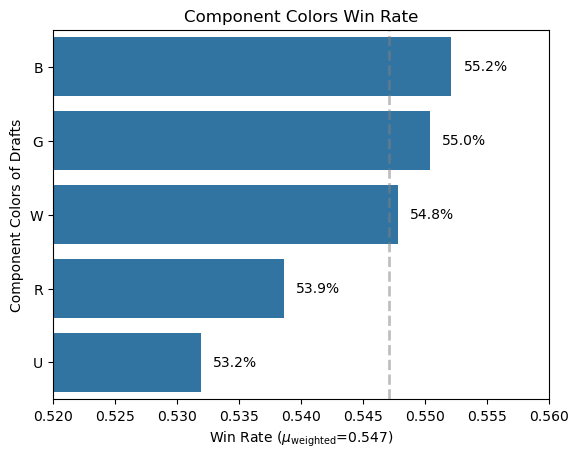

In [13]:
for color in ["W", "U", "B", "R", "G"]:
    color_wins[color] = color_wins["main_colors"].apply(
        lambda x: True if color in x else False
    )

dfs = []

for color in ["W", "U", "B", "R", "G"]:
    agg = color_wins.groupby(color).sum()
    agg["win_rate"] = agg["n_wins"] / agg["n_games"]
    dfs.append(pd.DataFrame({"component_color": color, "win_rate": agg.loc[True, "win_rate"]}, index=[0]))

df = pd.concat(dfs)
df = df.sort_values("win_rate", ascending=False).reset_index(drop=True)

plt.axvline(mean_win_rate, color="gray", linestyle="--", linewidth=2, alpha=0.5)
g = sns.barplot(data=df, x="win_rate", y="component_color")
g.set(xlim=(0.52, 0.56))
for index, row in df.iterrows():
    plt.text(row["win_rate"] + 0.001, index, f"{row['win_rate']:.1%}", va="center")
plt.title("Component Colors Win Rate")
plt.xlabel(r"Win Rate ($\mu_{\text{weighted}}$" + f"={mean_win_rate:0.3f})")
plt.ylabel("Component Colors of Drafts")
plt.show()

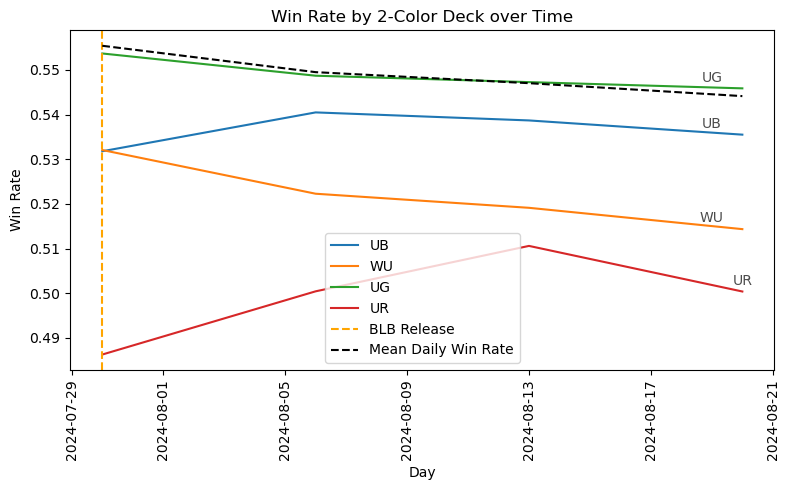

In [399]:
color_time = (
    (
        df_draft.filter(
            pl.col("main_colors").str.len_chars() == 2,
        )
        .group_by(pl.col("draft_time").dt.truncate("7d"), pl.col("main_colors"))
        .agg(
            pl.col("n_games").sum(),
            pl.col("n_wins").sum(),
        )
        .sort(by=["draft_time", "n_games"], descending=[False, True])
    )
    .with_columns(pl.col("draft_time") + timedelta(days=5))
    .collect()
    .to_pandas()
)

color_time["win_rate"] = color_time["n_wins"] / color_time["n_games"]

color_time_mean = (
    color_time[["draft_time", "n_wins", "n_games"]]
    .groupby("draft_time")
    .sum()
    .reset_index()
)
color_time_mean["win_rate"] = color_time_mean["n_wins"] / color_time_mean["n_games"]


color_decks = ["UB", "WU", "UG", "UR"]
color_time = color_time.loc[color_time["main_colors"].isin(color_decks)]

mask = color_time["draft_time"] == pd.to_datetime("2024-08-20")
labels = color_time.loc[mask].sort_values("win_rate", ascending=False)


plt.figure(figsize=(8, 5))
sns.lineplot(
    data=color_time,
    x="draft_time",
    y="win_rate",
    hue="main_colors",
    hue_order=color_decks,
    legend=True,
)

plt.axvline(
    x=pd.to_datetime("2024-07-30"), color="orange", linestyle="--", label="BLB Release"
)
for i, row in labels.iterrows():
    plt.text(
        row["draft_time"] + timedelta(days=(i % 2)-1),
        row["win_rate"] + 0.0015,
        str(row["main_colors"]),
        fontsize=10,
        alpha=0.7,
        ha="center",
    )

plt.plot(
    color_time_mean["draft_time"],
    color_time_mean["win_rate"],
    color="black",
    linestyle="--",
    label="Mean Daily Win Rate",
)
plt.xticks(rotation=90)
plt.title("Win Rate by 2-Color Deck over Time")
plt.xlabel("Day")
plt.ylabel("Win Rate")
plt.legend(loc="lower center")
plt.tight_layout()
plt.show()

### Color Freq vs Win Rate

Let us now compare the use rate versus the win rate.  If the player base is well calibrated to the 
win rate with their selections.

Below we can see that most of the two-color decks fall in a straight line, with two outliers.  The Blue-Red _Otters: 
Non-creature Spells_ deck under-performs relative to its use rate.  On the other hand, the Black-Red 
_Lizards: Opponents Lose Life_ deck is a sleeper, with the highest win rates, but selected less than 
the average two-color deck.  The reason for this under-selection is that Red doesn't perform well 
in general, so many drafters probably avoid drafting Red unless they get strong Black-Red cards 
early.  White, Green, and Black are perform well, so the BG, WG, and WB decks are easy to pivot among 
in the draft.

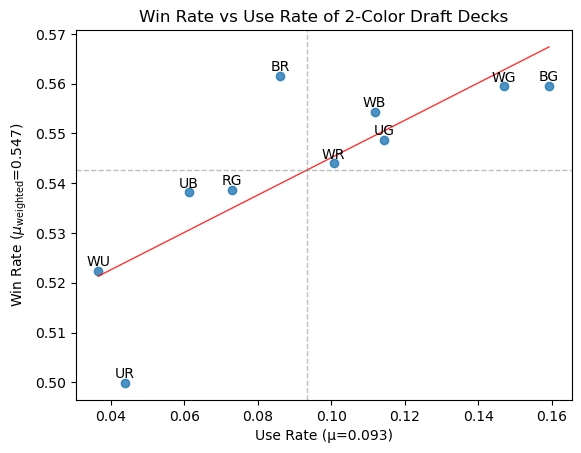

In [14]:
paired_df = color_wins[["main_colors", "win_rate", "loss_rate"]]
colors["use_rate"] = colors["len"] / colors["len"].sum()
select_colors = colors[["main_colors", "use_rate"]]
paired_df = paired_df.merge(select_colors, on="main_colors")

paired_filered_df = paired_df.loc[color_mask].reset_index(drop=True)

sns.regplot(
    data=paired_filered_df,
    x="use_rate",
    y="win_rate",
    scatter=True,
    ci=None,
    line_kws={"color": "red", "linewidth": 1, "alpha": 0.8},
)

for i, row in paired_filered_df.iterrows():
    plt.text(
        row["use_rate"],
        row["win_rate"]+0.001,
        str(row["main_colors"]),
        fontsize=10,
        ha="center",
    )

use_rate_mu = paired_filered_df["use_rate"].mean()
win_rate_mu = paired_filered_df["win_rate"].mean()

plt.axvline(use_rate_mu, color="gray", linestyle="--", linewidth=1, alpha=0.5)
plt.axhline(win_rate_mu, color="gray", linestyle="--", linewidth=1, alpha=0.5)
plt.title("Win Rate vs Use Rate of 2-Color Draft Decks")
plt.xlabel(f"Use Rate (μ={use_rate_mu:0.3f})")
plt.ylabel(r"Win Rate ($\mu_{\text{weighted}}$" + f"={mean_win_rate:0.3f})")
plt.show()

## Opposing Player Colors

We have data on the opposing player colors.  This is useful to understand the meta of the draft.  
For a given draft color combination, we can see the use rate by 17Lands players versus the use rate 
opponents.  Each draft color combination is also color coded if the win rate is above or below the 
17Lands player base average win rate.  A diagonal grey line is also added to show parity between the 
use by the 17Lands players and the general player base.

In the chart blow looks at 2-color drafts.  We can see that WG, BG, and UG are more favored by the 17Lands players and also 
has a higher win rate.  The UB color deck is more favored, but has a much lower win rate.  The other 
color pairs are on parity between the two player bases.

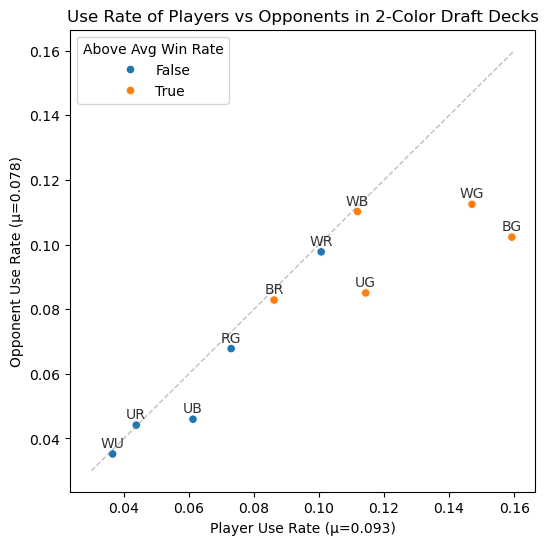

In [239]:
opp_colors = df_draft.group_by("opp_colors").len().sort(by='len', descending=True).collect().to_pandas()

opp_colors['opp_use_rate'] = opp_colors['len'] / opp_colors['len'].sum()
opp_colors = opp_colors.rename(columns=({"len": "opp_len"}))
opp_colors = opp_colors.merge(paired_df, left_on="opp_colors", right_on="main_colors", how="left")
opp_colors['Above Avg Win Rate'] = opp_colors['win_rate'] > mean_win_rate

plt.figure(figsize=(6, 6))

mask = opp_colors['main_colors'].str.len() == 2
opp_colors_filtered = opp_colors.loc[mask]

sns.scatterplot(
    data=opp_colors_filtered,
    x="use_rate",
    y="opp_use_rate",
    hue="Above Avg Win Rate"
)

plt.plot([0.03, 0.16], [0.03, 0.16], color="gray", linestyle="--", linewidth=1, alpha=0.5)

for i, row in opp_colors_filtered.iterrows():
    plt.text(
        row["use_rate"],
        row["opp_use_rate"]+0.002,
        str(row["opp_colors"]),
        fontsize=10,
        alpha=0.8,
        ha="center",
    )

use_rate_mu = opp_colors_filtered['use_rate'].mean()
opp_use_rate_mu = opp_colors_filtered['opp_use_rate'].mean()

plt.title("Use Rate of Players vs Opponents in 2-Color Draft Decks")
plt.xlabel(f"Player Use Rate (μ={use_rate_mu:0.3f})")
plt.ylabel(f"Opponent Use Rate (μ={opp_use_rate_mu:0.3f})")
plt.show()



Looking at the non-2-color drafts, we see that the 17Lands players are much less likely to pick any 
color companion that is not a 2-color deck.  The win rates are also lower for these decks, which some 
exceptions being the White, Green, and Black decks.

Based on this, it appears that if a drafter is selecting mono White, Green, or Black, they are better 
staying mono than drafting a 2-color deck into Blue or Red.  However, since the mono decks are 
so infrequent, the strong deck performance may be circumstantial to certain cards combinations and not 
generalize across the entire color set.

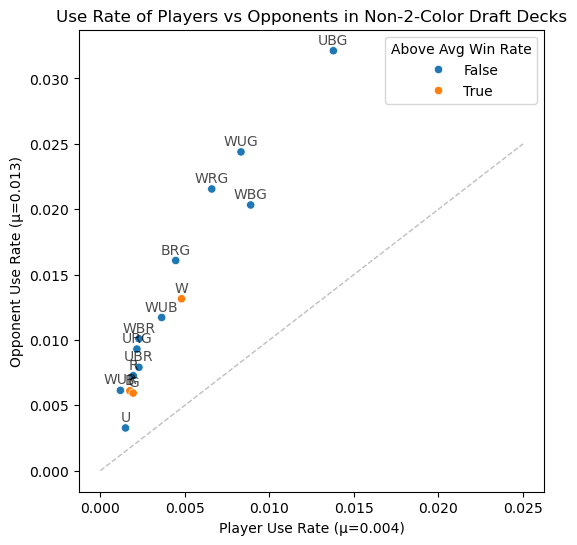

In [16]:
mask = opp_colors['main_colors'].str.len() != 2
mask &= opp_colors['use_rate'] > 0.001
opp_colors_filtered = opp_colors.loc[mask]

plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=opp_colors_filtered,
    x="use_rate",
    y="opp_use_rate",
    hue="Above Avg Win Rate"
)

plt.plot([0.0, 0.025], [0.0, 0.025], color="gray", linestyle="--", linewidth=1, alpha=0.5)

for i, row in opp_colors_filtered.iterrows():
    plt.text(
        row["use_rate"],
        row["opp_use_rate"]+0.0005,
        str(row["opp_colors"]),
        fontsize=10,
        alpha=0.7,
        ha="center",
    )

use_rate_mu = opp_colors_filtered['use_rate'].mean()
opp_use_rate_mu = opp_colors_filtered['opp_use_rate'].mean()

plt.title("Use Rate of Players vs Opponents in Non-2-Color Draft Decks")
plt.xlabel(f"Player Use Rate (μ={use_rate_mu:0.3f})")
plt.ylabel(f"Opponent Use Rate (μ={opp_use_rate_mu:0.3f})")
plt.show()


### Matrix 2-Color vs 2-Color

Let's now see how each pairing of the two-color decks compare.  This will give us insight into 
strengths and weaknesses of individual decks.

First we will look at the number of games played between each pairing.  The rows and columns are 
sorted based on the maximum frequency of player deck pairings, with BG vs WG the most frequent, 
followed by WG vs WG.  The average number of games played between each pairing was 5,031.

As we saw above, the players use BG, WG, and UG more often than opponents, 
with the other color pairs being used at near parity.

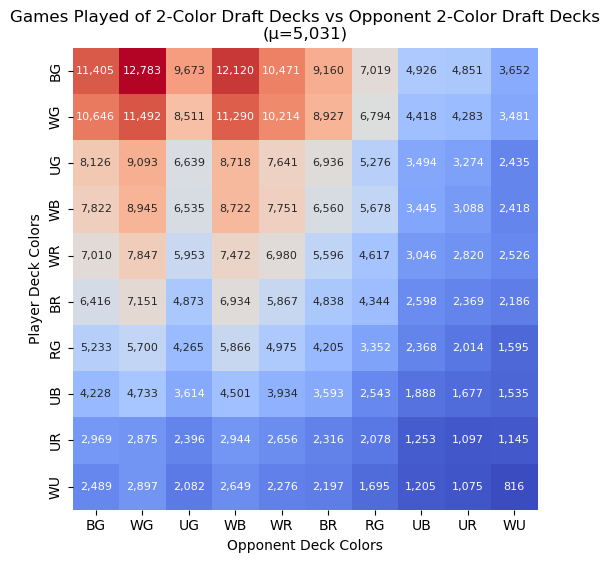

In [39]:
dual_colors = (
    df_draft.filter(
        pl.col("opp_colors").str.len_chars() == 2,
        pl.col("main_colors").str.len_chars() == 2,
        # pl.col("rank") == 'mythic',
    )
    .group_by(["opp_colors", "main_colors"])
    .agg(
        pl.col("n_games").sum(),
        pl.col("n_wins").sum(),
        pl.col("n_losses").sum(),
    )
    .sort(by="n_games", descending=True)
    .collect()
)
dual_colors = dual_colors.to_pandas()
dual_colors["win_rate"] = dual_colors["n_wins"] / dual_colors["n_games"]
dual_colors["loss_rate"] = dual_colors["n_losses"] / dual_colors["n_games"]
dual_colors = dual_colors.sort_values("win_rate", ascending=False).reset_index(
    drop=True
)

dual_matrix = dual_colors.pivot(
    index="main_colors", columns="opp_colors", values="n_games"
)

means = dual_matrix.max(axis=1).sort_values(ascending=False)
dual_matrix = dual_matrix.loc[means.index, means.index]
pair_mean = dual_matrix.mean().mean()

plt.figure(figsize=(6, 6))
sns.heatmap(
    dual_matrix,
    annot=True,
    fmt=",.0f",
    cmap="coolwarm",
    cbar=False,
    annot_kws={"fontsize": 8},
)
plt.title(
    "Games Played of 2-Color Draft Decks vs Opponent 2-Color Draft Decks\n(μ="
    + f"{pair_mean:,.0f})"
)
plt.xlabel("Opponent Deck Colors")
plt.ylabel("Player Deck Colors")
plt.show()

Next we look at the pair-wise win rates for players.  

The most interesting observation is that the 17Lands player base is strong in most matchups, with 
a large exception for the UR deck.  On average, the UR matchups under-perform by ~4 percentage points 
versus similar matchups.  The UR-UR matchup is extremely low, and is the only like-paired matchup 
that has lower than even odds of winning.

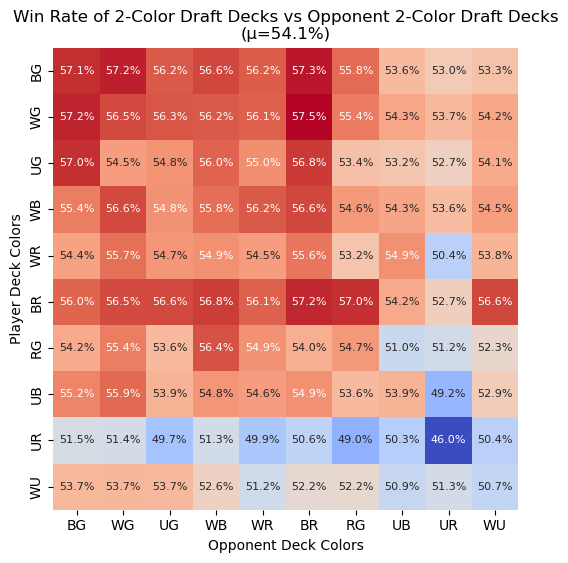

In [35]:
dual_matrix = dual_colors.pivot(
    index="main_colors", columns="opp_colors", values="win_rate"
)

dual_matrix = dual_matrix.loc[means.index, means.index]

pair_mean = dual_matrix.mean().mean()

plt.figure(figsize=(6, 6))
sns.heatmap(
    dual_matrix,
    annot=True,
    fmt=".1%",
    cmap="coolwarm",
    cbar=False,
    annot_kws={"fontsize": 8},
)
plt.title("Win Rate of 2-Color Draft Decks vs Opponent 2-Color Draft Decks\n(μ=" + f"{pair_mean:0.1%})")
plt.xlabel("Opponent Deck Colors")
plt.ylabel("Player Deck Colors")
plt.show()

## Player Rank

To get a sense of player skill, below I plotted the number of wins by the player rank.  I do not 
have player IDs, so I cannot track individual player performance.  However, we can see the average 
performance of the player base. I also cannot track the number of drafts per player, so more 
frequent players will be over-represented.

While we do not have opponent rankings, we can infer that most opponents will be of the same rank 
as the player.  This is because the Arena draft system matches players with similar records.  Each 
ranked season is about 1 month long.  Ranks have "rank decay" between seasons, meaning an the start 
of the next season, a players rank will be lower than the previous season, requiring them to play 
more games to get back to their previous rank.  

So our snapshot of each rank is a mix of lower-skill, end-of-season players at their peak, and 
higher-skill, start-of-season players who are climbing back up the ranks.

Below we see that most drafts are played by players in the Platinum ranks.

In [315]:
draft_rank = df_draft.group_by("rank").agg(
    pl.col("n_wins").len().alias('len'), 
    pl.col("n_wins").sum(), 
    pl.col("n_games").sum()
).sort(by='n_wins', descending=True)

In [316]:
ordered_ranks = {
    0: "bronze",
    1: "silver",
    2: "gold",
    3: "platinum",
    4: "diamond",
    5: "mythic",
}

ordered_ranks_df = pl.LazyFrame(
    {"rank_value": list(ordered_ranks.keys()), "rank": list(ordered_ranks.values())}
).with_columns(
    # Create the rank_name column
    (pl.col("rank_value").cast(str) + " " + pl.col("rank").str.to_uppercase()).alias(
        "rank_name"
    )
)


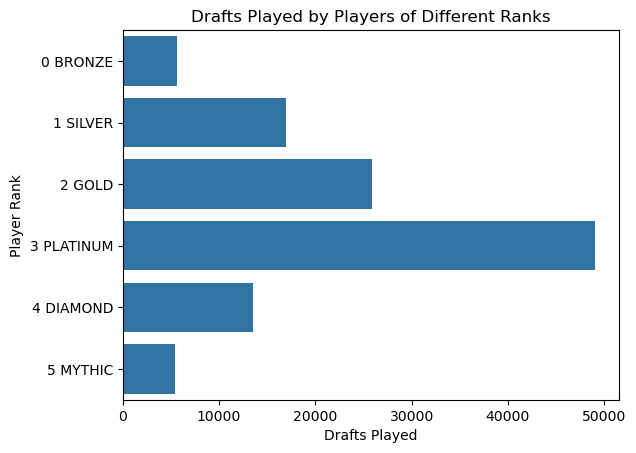

In [317]:
ranks = (
    ordered_ranks_df.join(draft_rank, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()

sns.barplot(data=ranks, y="rank_name", x="len")

plt.title("Drafts Played by Players of Different Ranks")
plt.xlabel("Drafts Played")
plt.ylabel("Player Rank")
plt.show()

Here we see that the win rates vary by rank.  The higher ranks have higher win rates.  Bronze has 
by far the lowest win rate, indicating new or unskilled players.  The Silver rank has the highest 
win rate.  This may be from the large number of Gold and Platinum players that reset to Silver at 
the start of the season and quickly climb back up the ranks.

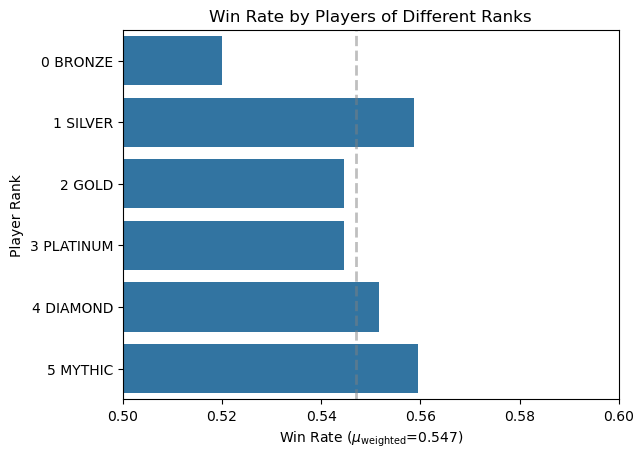

In [318]:
ranks['win_rate'] = ranks['n_wins'] / ranks['n_games']

plt.axvline(mean_win_rate, color="gray", linestyle="--", linewidth=2, alpha=0.5)
sns.barplot(data=ranks, y='rank_name', x='win_rate')
plt.xlim(0.5, 0.60)

plt.title("Win Rate by Players of Different Ranks")
plt.xlabel(r"Win Rate ($\mu_{\text{weighted}}$" + f"={mean_win_rate:0.3f})")
plt.ylabel("Player Rank")
plt.show()

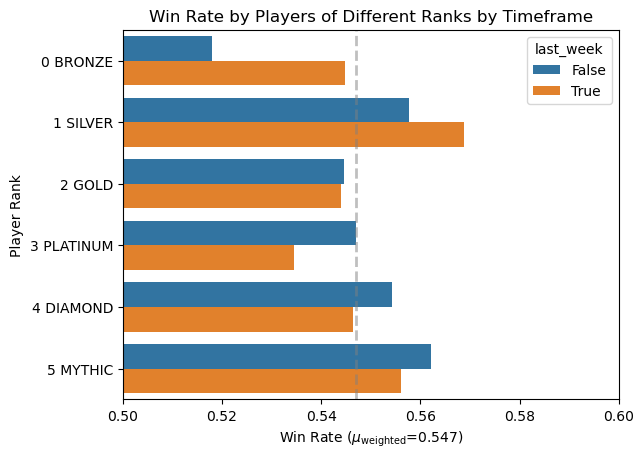

In [319]:
draft_rank = (
    df_draft.with_columns(
        (pl.col("draft_time") > pd.to_datetime("2024-08-13")).alias("last_week")
    )
    .group_by(["rank", "last_week"])
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
    )
    .sort(by="n_wins", descending=True)
)


week_ranks = (
    ordered_ranks_df.join(draft_rank, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()

week_ranks["win_rate"] = week_ranks["n_wins"] / week_ranks["n_games"]

plt.axvline(mean_win_rate, color="gray", linestyle="--", linewidth=2, alpha=0.5)
sns.barplot(data=week_ranks, y="rank_name", x="win_rate", hue="last_week")
plt.xlim(0.5, 0.60)

plt.title("Win Rate by Players of Different Ranks by Timeframe")
plt.xlabel(r"Win Rate ($\mu_{\text{weighted}}$" + f"={mean_win_rate:0.3f})")
plt.ylabel("Player Rank")
plt.show()

Below is a view for the number of games played per draft for each rank.  While not identical, 
the pattern is very similar to the above chart of win rate.

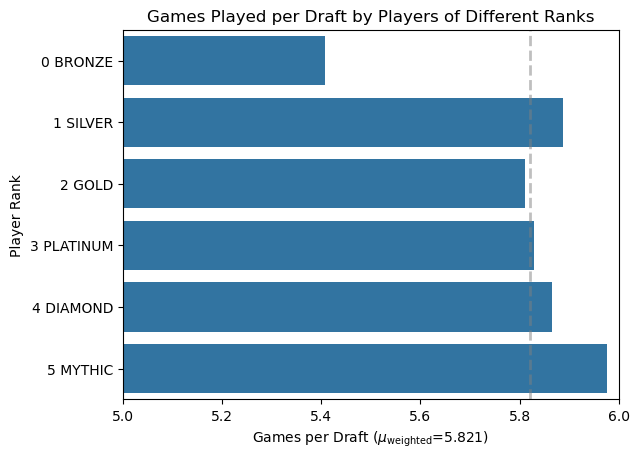

In [404]:
ranks["games_per_draft"] = ranks["n_games"] / ranks["len"]
mean_games_played = df_draft.select(pl.col("n_games").mean()).collect().to_numpy()[0][0]

plt.axvline(mean_games_played, color="gray", linestyle="--", linewidth=2, alpha=0.5)
sns.barplot(data=ranks, y="rank_name", x="games_per_draft")
plt.xlim(5, 6)

plt.title("Games Played per Draft by Players of Different Ranks")
plt.xlabel(r"Games per Draft ($\mu_{\text{weighted}}$" + f"={mean_games_played:0.3f})")
plt.ylabel("Player Rank")
plt.show()

### Ranks over Time

We next look at the number of drafts played for each rank over the dataset.  Since the BLB set was 
released two days before the season start, I have truncated the data at 08-01 to avoid the rank 
decay.  

The first few days are chaotic, as the BLB set released on 07-30, but with 07-31 being the first 
full day with games recorded.  08-01 was when the next ranked season started, resulting in rank 
decay, which is especially pronounced in Mythic and Diamond gameplay.

An interesting pattern is seen starting on 08-01, with Gold quickly decaying after the initial peak of 3800 drafts per day. 
The Platinum rank having a quick peak during days 4-6, then dropping.  
The Diamond rank has a slow climb with a plateau during days 8-13 and then slowly retracing.  
The Mythic rank starts at zero, then very slowly climbs te a peak of 500 drafts per day peak at 13-16 days.

From this chart, we can't tell how much of the decline at each ranks is due to player advancement, and how 
much is loss of interest after the initial excitement of a new season.  In the following charts, 
I will normalize to the total drafts played to better account for overall decrease in gameplay.

In [322]:
rank_time_df = (
    df_draft.group_by(
        pl.col("draft_time").dt.truncate("1d")  # Truncate datetime to day
    )
    .agg(
        [
            pl.col("rank")
            .value_counts()
            .alias("rank_counts")  # Count occurrences of each rank
        ]
    )
    .explode("rank_counts")
    .with_columns(
        # Extract rank and count from the exploded struct
        pl.col("rank_counts").struct.field("rank").alias("rank"),
        pl.col("rank_counts").struct.field("count").alias("count"),
    )
    .drop("rank_counts")
    .join(ordered_ranks_df, on="rank", how="left")
    .sort(by=["draft_time", "rank_name"], descending=False)
    .collect()
    .to_pandas()
)

In [323]:
print(f"Total Time Interval: {(rank_time_df["draft_time"].max() - rank_time_df["draft_time"].min())}")

Total Time Interval: 19 days 00:00:00


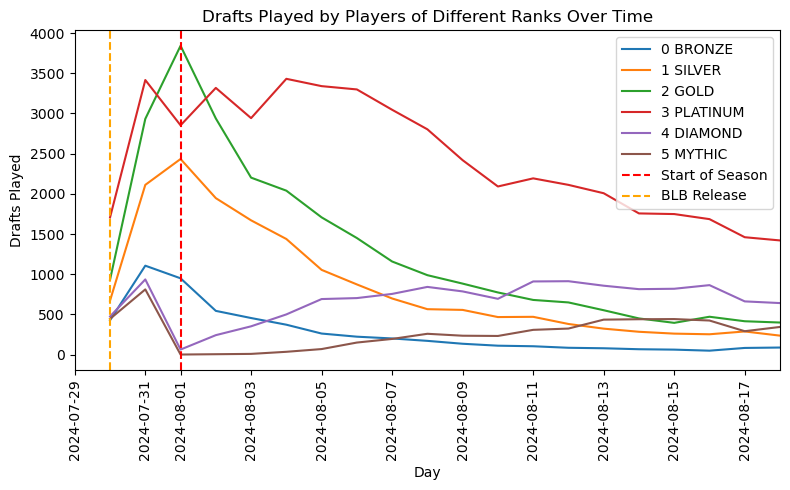

In [324]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_df, x="draft_time", y="count", hue="rank_name")
plt.xlim(pd.to_datetime("2024-07-29"), rank_time_df["draft_time"].max())

plt.axvline(
    x=pd.to_datetime("2024-08-01"), color="red", linestyle="--", label="Start of Season"
)
plt.axvline(
    x=pd.to_datetime("2024-07-30"), color="orange", linestyle="--", label="BLB Release"
)
plt.xticks(rotation=90)
plt.title("Drafts Played by Players of Different Ranks Over Time")
plt.xlabel("Day")
plt.ylabel("Drafts Played")
plt.legend()
plt.tight_layout()
plt.show()

Here we can see the numbers of drafts played.  It is interesting that since both the release of BLB 
and the start of the new season coincided, the player interest in draft was very high with a peak 
of 11,300 drafts played on 07-31.  The rate of play decayed over the weeks, with the minimum recorded 
of 3,100 occurring on 08-17.  

The decline is nearly monotonic, with slight upticks occurring on 
the Saturdays of 08-04 and 08-11.  This shows that the weekly seasonality is of minor effect.

It is interesting how releasing new sets increases player engagement.  The introduction of the 
new season on 08-01 doesn't seem to have caused an uptick in play, but this is a weak inference.  
From this data, I understand the economic motivation for releasing new sets for digital 
engagement on Arena.  One could infer that paper play would follow a similar pattern, with draft 
play consuming many more booster packs a few weeks after a launch of a new set.

It would be interesting to compare this curve across set releases to get an indication of set-by-set 
preferences of the player base.

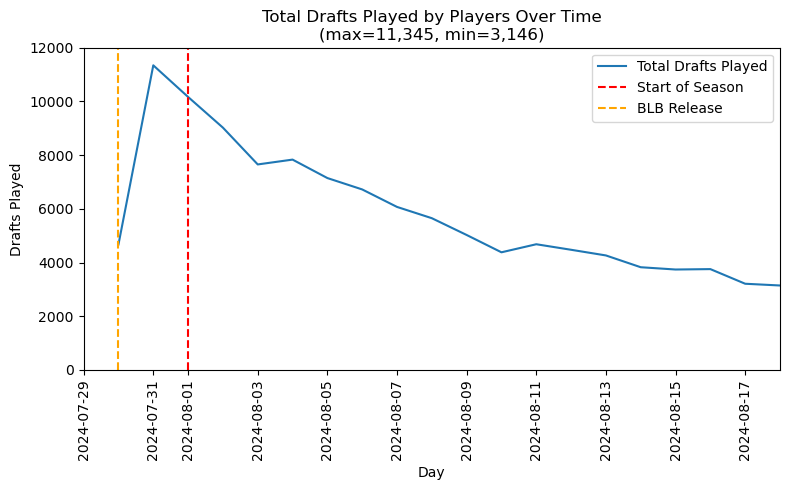

In [325]:
rank_time_sum = (
    rank_time_df[["draft_time", "count"]].groupby(["draft_time"]).sum().reset_index()
)
plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_sum, x="draft_time", y="count", label="Total Drafts Played")
plt.xlim(pd.to_datetime("2024-07-29"), rank_time_sum["draft_time"].max())
plt.ylim(0, 12000)
plt.axvline(
    x=pd.to_datetime("2024-08-01"), color="red", linestyle="--", label="Start of Season"
)
plt.axvline(
    x=pd.to_datetime("2024-07-30"), color="orange", linestyle="--", label="BLB Release"
)

plt.xticks(rotation=90)
plt.title(("Total Drafts Played by Players Over Time\n"
           "(max=" + f"{rank_time_sum['count'].max():,.0f}, "
           "min=" + f"{rank_time_sum['count'].min():,.0f})"))
plt.xlabel("Day")
plt.ylabel("Drafts Played")
plt.legend()
plt.tight_layout()
plt.show()

Next we normalize for the total games played to see relative ranked play across the player base. 

We can now see the relative rank play much more clearly.  
After the new season start, Gold shows a linear decay as the player base advances to Platinum.  
The Platinum has a much more prolonged plateau, showing an equilibrium of new players joining the 
rank versus existing players advancing.  
Both Diamond and Mythic start with minimal players, but gradually increase in play nearly monotonically 
at differing rates.

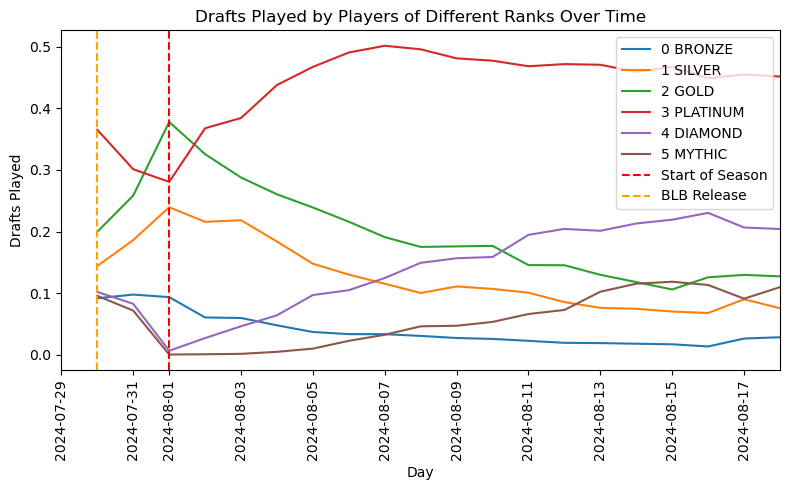

In [326]:
rank_time_df2 = rank_time_df.merge(rank_time_sum, on="draft_time", suffixes=("", "_sum"))
rank_time_df2["rank_pct"] = rank_time_df2["count"] / rank_time_df2["count_sum"]

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_df2, x="draft_time", y="rank_pct", hue="rank_name")
plt.xlim(pd.to_datetime("2024-07-29"), rank_time_sum["draft_time"].max())

plt.axvline(
    x=pd.to_datetime("2024-08-01"), color="red", linestyle="--", label="Start of Season"
)
plt.axvline(
    x=pd.to_datetime("2024-07-30"), color="orange", linestyle="--", label="BLB Release"
)

plt.xticks(rotation=90)
plt.title("Drafts Played by Players of Different Ranks Over Time")
plt.xlabel("Day")
plt.ylabel("Drafts Played")
plt.legend()
plt.tight_layout()
plt.show()

### Low vs High Rank Players

Now let's compare the performance of player rank versus success.  I will take the 3 two-color decks 
that were outliers in the previous use-rate versus win-rate chart.  I'll use the BG deck with a high 
use and win rate, the BR deck with a high win rate and lower use rate, and the UR deck, with the 
very low use rate and an extremely low win rate.

Below we can see the overall performance of players with these decks.  We have two categories.  The 
first is the week of play and the second is the if the player is in the elite ranks of Diamond or 
Mythic. 

For BG, the most played deck, the performance across weeks and ranks shows no clear trend.  
However, the BR and UR decks, which are less played, both sets of ranked players showed noticeable 
gains in win rate from week one to two.  This indicates that the 17Lands player base learned how to better 
use these less favorable decks, regardless of rank.

Note that for the first week of play, the Mythic and Diamond play base is very small.

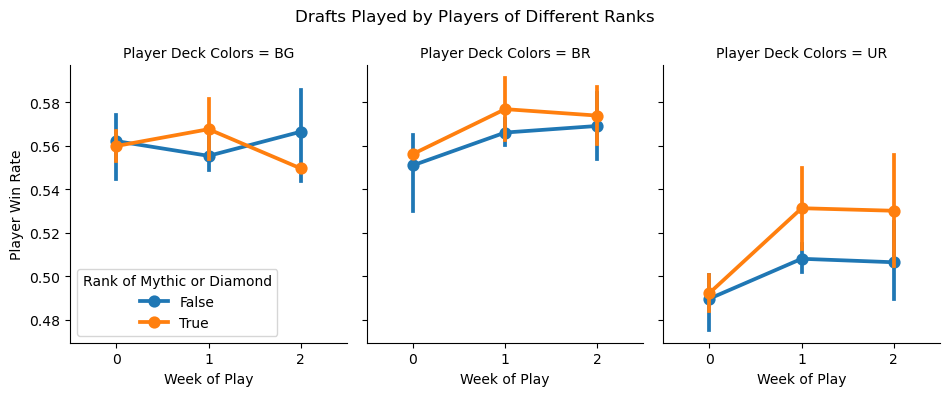

In [405]:
{
    "tags": ["hide-input"]
}
draft_rank_deck = (
    df_draft.with_columns(
        (
            (
                (pl.col("draft_time") - pd.to_datetime("2024-07-30"))
                / pd.Timedelta(days=7)
            ).cast(pl.Int64)
        ).alias("week"),
        (pl.col("rank").is_in(["mythic", "diamond"])).alias("elite_ranks"),
    )
    .filter(
        pl.col("main_colors").is_in(["BG", "BR", "UR"]),
    )
    .group_by(["rank", "main_colors", "week"])
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
        pl.col("elite_ranks").first(),
    )
    .sort(by="n_wins", descending=True)
)

ranks_deck = (
    ordered_ranks_df.join(draft_rank_deck, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()
ranks_deck["win_rate"] = ranks_deck["n_wins"] / ranks_deck["n_games"]

ranks_deck = ranks_deck.rename(
    columns={
        "elite_ranks": "Rank of Mythic or Diamond",
        "week": "Week of Play",
        "main_colors": "Player Deck Colors",
        "win_rate": "Player Win Rate",
    }
)

sns.catplot(
    data=ranks_deck,
    x="Week of Play",
    y="Player Win Rate",
    hue="Rank of Mythic or Diamond",
    kind="point",
    col="Player Deck Colors",
    height=4,
    aspect=0.8,
    legend_out=False
)
plt.suptitle("Drafts Played by Players of Different Ranks")
plt.tight_layout()
plt.show()

## Mulligans

## Turn Conuts

## Builds

## Starting Player

In [27]:
## Start

In [28]:
## 

In [29]:
## Turn

In [30]:
## Tu